# Modelling Domestic Space in English and Irish Fiction
## English USE/BERT Model for predicting the probability of a segment set in domestic space

This Jupyter notebook takes as input an Excel sheet with manually labeled data for the fine-tuning of the Keras English uncased BERT model for the classification task of domestic space detection. The process is divided into two steps: the first is the classification for garbage and its exclusion from a second set, which is then classified into the two classes "domestic" and "other".

In [46]:
import os
os.environ['TF_USE_LEGACY_KERAS']='1'

In [47]:
#MODEL 1: TRASH DETECTION
#read in the training data
#ignore the warning "("Workbook contains no default style, apply openpyxl's default")"

import pandas as pd
df_trash=pd.read_excel('/Users/.../Domestic_Space_Project/DataForClassifier/TrainingDataForTrashDetector.xlsx')

/opt/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [48]:
#look at the top of the table
df_trash.head()

,Passage,Tag
0,"Was he ?"" said Lilly. "" I didn't see hir n!"" ""...",not_trash
1,"Yhatever he had done, it was to establish the ...",not_trash
2,"‚Äö√Ñ¬¢-You will find/' said Brerewood, handin...",not_trash
3,"""' I !"" exclaimed John in alarm (he might lose...",not_trash
4,I only know it would be a bad business for him...,not_trash


In [49]:
#translate text labels to numeric
df_trash['Labels']=df_trash['Tag'].map({'not_trash': 0, 'trash':1})
#drop the "Tag" column
df_trash=df_trash.drop(["Tag"], axis=1)

In [50]:
#import libraries etc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [51]:
#define number of classes (more important if you have multiple)
num_classes = len(df_trash["Labels"].value_counts())

In [52]:
#load tensorflow and data division
#!pip install tensorflow #if needed
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [53]:
#turn numeric labels into categorical variables
y=tf.keras.utils.to_categorical(df_trash["Labels"].values, num_classes=num_classes)

#split sample into training and test sets
x_train, x_test, y_train, y_test=train_test_split(df_trash['Passage'], y, test_size=0.25)

In [54]:
#import Bert Models
import tensorflow_hub as hub
import tensorflow_text as text

#create preprocessor and encoder/bert models
#preprocessor = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
#encoder = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/mnli/2')

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [55]:
#create model parameters
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)
model_trash = tf.keras.Model(i, x)

In [56]:
#create functions for evaluating the model
import tensorflow.keras.backend as K

def balanced_recall(y_true, y_pred):
	"""This function calculates the balanced recall metric recall = TP /(TP+FN)"""
	recall_by_class=0
	for i in range(y_pred.shape[1]):
		y_pred_class=y_pred[:, i]
		y_true_class=y_true[:, i]
		true_positives=K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
		possible_positives=K.sum(K.round(K.clip(y_true_class, 0, 1)))
		recall = true_positives / (possible_positives +K.epsilon())
		recall_by_class = recall_by_class + recall
	return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
	"""This function calculates the balanced precision metric precision = TP / (TP+FP)"""
	precision_by_class=0
	for i in range(y_pred.shape[1]):
		y_pred_class = y_pred[:, i]
		y_true_class = y_true[:, i]
		true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
		predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
		precision = true_positives / (predicted_positives + K.epsilon())
		precision_by_class = precision_by_class + precision
	return precision_by_class / y_pred.shape[1]


def balanced_f1_score(y_true, y_pred):
	"""This function calculates the F1 score metric"""
	precision = balanced_precision(y_true, y_pred)
	recall = balanced_recall(y_true, y_pred)
	return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [12]:
#run the model

n_epochs = 20
METRICS = [ tf.keras.metrics.CategoricalAccuracy(name="accuracy"), balanced_recall, balanced_precision, balanced_f1_score]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model_trash.compile(optimizer = "adam", loss = "categorical_crossentropy",metrics = METRICS)

model_trash_fit = model_trash.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_test, y_test), callbacks = [earlystop_callback])

Epoch 1/20
53/53 [==============================] - 111s 2s/step - loss: 0.2457 - accuracy: 0.9091 - balanced_recall: 0.9073 - balanced_precision: 0.9076 - balanced_f1_score: 0.9059 - val_loss: 0.0448 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoch 2/20
53/53 [==============================] - 108s 2s/step - loss: 0.0335 - accuracy: 1.0000 - balanced_recall: 1.0000 - balanced_precision: 1.0000 - balanced_f1_score: 1.0000 - val_loss: 0.0199 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoch 3/20
53/53 [==============================] - 107s 2s/step - loss: 0.0177 - accuracy: 1.0000 - balanced_recall: 1.0000 - balanced_precision: 1.0000 - balanced_f1_score: 1.0000 - val_loss: 0.0121 - val_accuracy: 1.0000 - val_balanced_recall: 1.0000 - val_balanced_precision: 1.0000 - val_balanced_f1_score: 1.0000
Epoch 4/20
53/53 [=========================

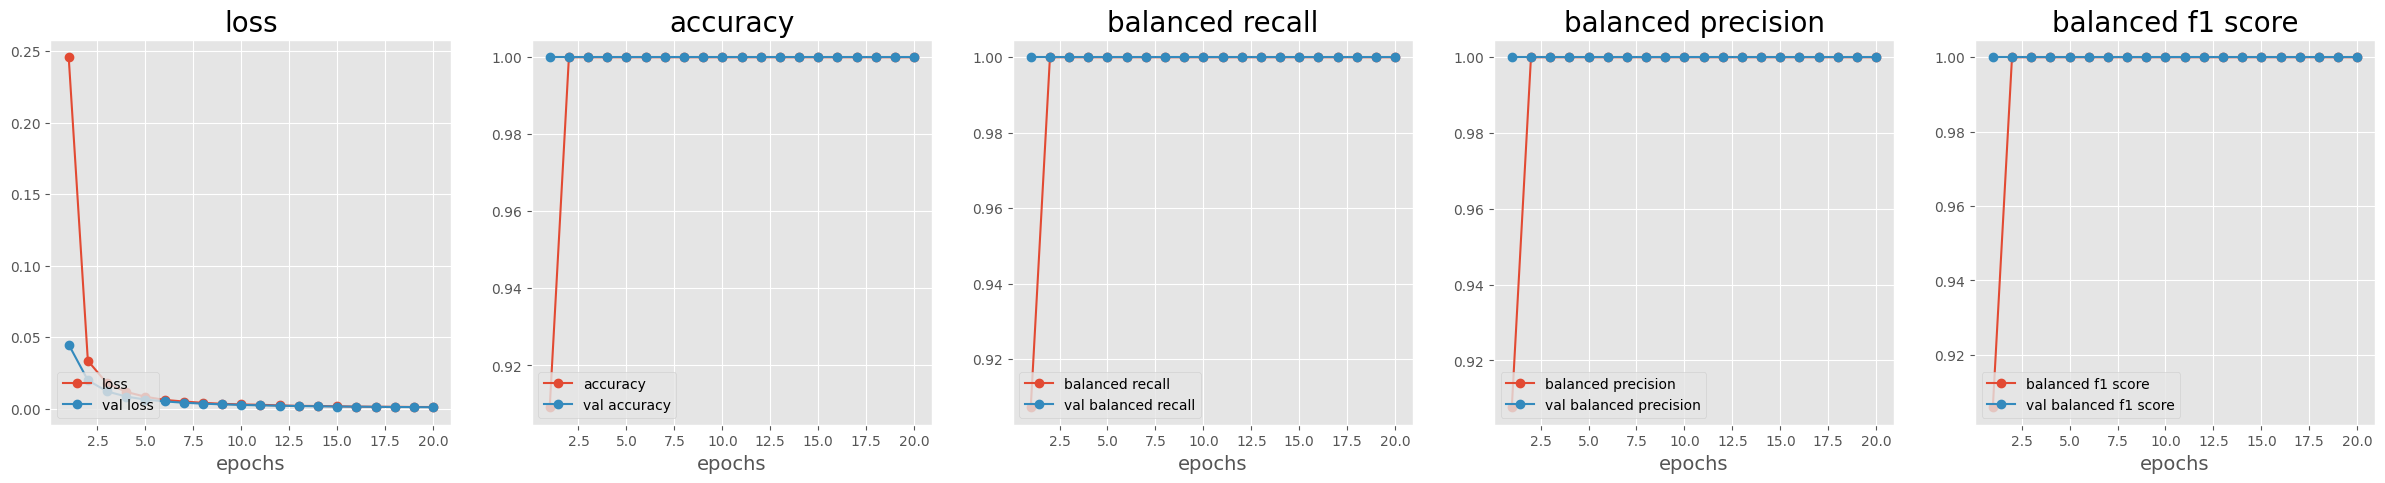

In [13]:
#plot change in accuracy scores over epochs
x = list(range(1, 20+1))#has to be adapted to the actual number of epochs +1
metric_list = list(model_trash_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
    ax[i].plot(x, model_trash_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_trash_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")
    #ax[i].set_ylim([0,1])
    
fig.savefig('/Users/.../Domestic_Space_Project/DataForClassifier/ClassificationSuccess_TrashDetection.pdf')



In [50]:
model_trash.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

## Save the trash detector model for reuse 

In [ ]:
model_trash.save("/Users/.../Domestic_Space_Project/DataForClassifier/TwoModelSolution/TrashDetectorModel.keras")

In [1]:
#TO LOAD THE SAVED TRASH DETECTION MODEL
reloaded_trashdetector_model = tf.keras.models.load_model("/Users/.../Domestic_Space_Project/DataForClassifier/TwoModelSolution/TrashDetectorModel.keras")


# try saving the weights separately to reload them faster (Tensorflow help page)
# or save it as HDF5 format 
# https://www.tensorflow.org/tutorials/keras/save_and_load 

# Train the Domestic Space Detector Model

In [57]:
#MODEL 2: DOMESTIC SPACE DETECTION
#Read in the training data, you can ignore the warning "("Workbook contains no default style, apply openpyxl's default")"
import pandas as pd
df_domestic=pd.read_excel('/Users/.../Domestic_Space_Project/DataForClassifier/AnnotationTablesForClassifier/TrainingDataWithNoTrash.xlsx')

/opt/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [58]:
#look at the top of the table
df_domestic.head()

,Passage,Tag
0,"Was he ?"" said Lilly. "" I didn't see hir n!"" ""...",domestic
1,"Yhatever he had done, it was to establish the ...",other
2,"‚Äö√Ñ¬¢-You will find/' said Brerewood, handin...",domestic
3,"""' I !"" exclaimed John in alarm (he might lose...",domestic
4,I only know it would be a bad business for him...,domestic


In [59]:
#translate text labels to numeric
df_domestic['Labels']=df_domestic['Tag'].map({'other': 0, 'domestic':1})
#drop the "Tag" column
df_domestic=df_domestic.drop(["Tag"], axis=1)

In [60]:
#import libraries etc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [61]:
#define number of classes (more important if you have multiple)
num_classes = len(df_domestic["Labels"].value_counts())

In [62]:
#load tensorflow and data division
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [63]:
#turn numeric labels into categorical variables
y=tf.keras.utils.to_categorical(df_domestic["Labels"].values, num_classes=num_classes)
#split sample into training and test sets
x_train, x_test, y_train, y_test=train_test_split(df_domestic['Passage'], y, test_size=0.25)

In [64]:
#import Bert Models
import tensorflow_hub as hub
import tensorflow_text as text

#create preprocessor and encoder/bert models
#preprocessor = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
#encoder = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/mnli/2')

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [65]:
#create model parameters
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)
model_domestic = tf.keras.Model(i, x)

In [66]:
#run the model

n_epochs = 20
METRICS = [ tf.keras.metrics.CategoricalAccuracy(name="accuracy"), balanced_recall, balanced_precision, balanced_f1_score]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model_domestic.compile(optimizer = "adam", loss = "categorical_crossentropy",metrics = METRICS)

model_domestic_fit = model_domestic.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_test, y_test), callbacks = [earlystop_callback])

Epoch 1/13
27/27 [==============================] - 52s 2s/step - loss: 0.6974 - accuracy: 0.5709 - balanced_recall: 0.5554 - balanced_precision: 0.5576 - balanced_f1_score: 0.5545 - val_loss: 0.6395 - val_accuracy: 0.6175 - val_balanced_recall: 0.5816 - val_balanced_precision: 0.6312 - val_balanced_f1_score: 0.6001
Epoch 2/13
27/27 [==============================] - 46s 2s/step - loss: 0.6226 - accuracy: 0.6460 - balanced_recall: 0.6379 - balanced_precision: 0.6484 - balanced_f1_score: 0.6428 - val_loss: 0.5923 - val_accuracy: 0.6877 - val_balanced_recall: 0.6550 - val_balanced_precision: 0.7453 - val_balanced_f1_score: 0.6960
Epoch 3/13
27/27 [==============================] - 47s 2s/step - loss: 0.5628 - accuracy: 0.7186 - balanced_recall: 0.7072 - balanced_precision: 0.7102 - balanced_f1_score: 0.7086 - val_loss: 0.5582 - val_accuracy: 0.7684 - val_balanced_recall: 0.7433 - val_balanced_precision: 0.8039 - val_balanced_f1_score: 0.7710
Epoch 4/13
27/27 [============================

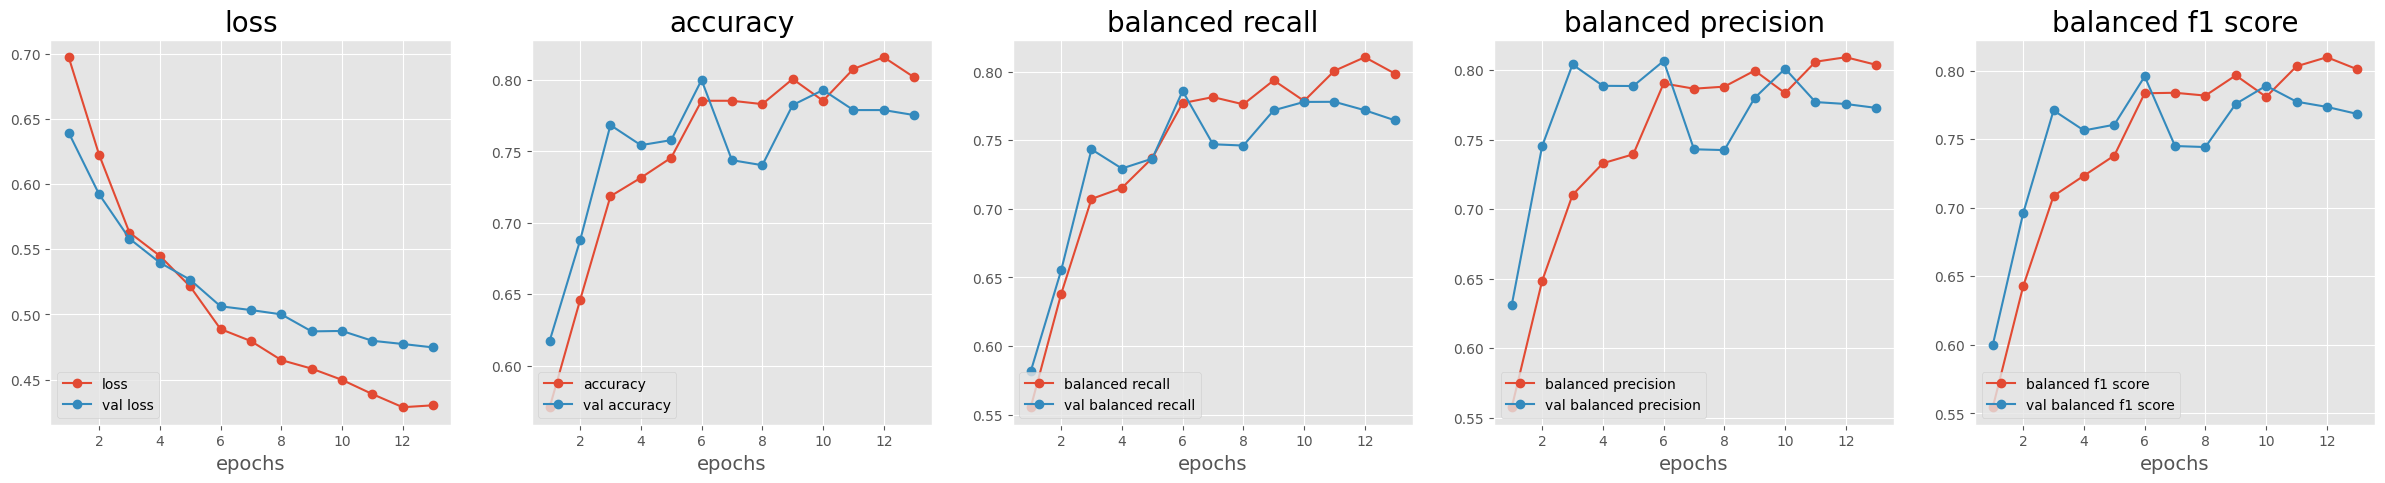

In [67]:
#plot change in accuracy scores over epochs
x = list(range(1, 20+1))#has to be adapted to the actual number of epochs +1
metric_list = list(model_domestic_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
    ax[i].plot(x, model_domestic_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_domestic_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")
    #ax[i].set_ylim([0,1])
    
fig.savefig('/Users/.../Domestic_Space_Project/DataForClassifier/ClassificationSuccess_DomesticSpacePrediction.pdf')


In [51]:
model_domestic.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

## Save the trash detector model for reuse 

In [69]:
#TO SAVE THE MODEL
model_domestic.save("/Users/.../Domestic_Space_Project/TwoModelSolution/DomesticSpaceModel.keras")

In [ ]:
#TO LOAD THE SAVED MODEL
reloaded_domestic_model = tf.keras.models.load_model("/Users/.../Domestic_Space_Project/TwoModelSolution/DomesticSpaceModel.keras")

# Functions for Evaluating the model

## Evaluation of the Trash detection

In [95]:
#function for predicting new sentences with trash detector
def predict_class(reviews):
  return [np.argmax(pred) for pred in model_trash.predict(reviews)]

In [ ]:
#imports original test data for trash detection (withhold from training data)
test_trash = pd.read_csv('/Users/.../Domestic_Space_Project/DataForClassifier/WithheldSampleFromOriginalTraining_TrashDetector.csv')

#extracts the passage column and stores it in the list for prediction
test_trash_text = test_trash['Passage'].tolist()

In [96]:
#uses the model_trash aka trash detector to predict whether a segment is "trash" or "not trash"
perc_probability=model_trash.predict(test_trash_text)

2/2 [==============================] - 3s 1s/step


In [97]:
#defines a new dataframe to store the predictions of each segment and concatenates it with the previously loaded dataframe containing the segment plus additional metadata and manual annotations as a test base
prob_df = pd.DataFrame(perc_probability, columns=['not_trash', 'trash'])
combined_table=pd.concat([test_trash, prob_df], axis=1)

In [98]:
#store the combined table to a csv for error analysis
combined_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/WithheldSampleFromOriginalTraining_TrashDetector_TrashDetectionPredictions.csv')

In [99]:
#show the new table
combined_table

,Passage,Tag,Unnamed: 2,not_trash,trash
0,Hall is well worthy to look out upon such a su...,not_trash,NaN,0.655042,0.344958
1,The man who would map out the currents of the ...,not_trash,NaN,0.598782,0.401218
2,He had thrown the brand of wickedness and rebe...,not_trash,NaN,0.746360,0.253640
3,But Henry always had the comfortable faculty o...,not_trash,NaN,0.431565,0.568435
4,"It so, and let us part, Since love like mine h...",not_trash,NaN,0.772480,0.227520
...,...,...,...,...,...
59,"''Thank ye, Mr. Quaver,"" replied the widow, st...",not_trash,NaN,0.602432,0.397568
60,In either case should they chance to outnumber...,not_trash,NaN,0.654027,0.345973
61,^ OHN MORRISON took his refusal ^^V in the sam...,not_trash,NaN,0.693351,0.306649
62,Your visitant appeared too much under the infl...,not_trash,NaN,0.826911,0.173089


In [19]:
#Import original validation data for trash detection
val_trash = pd.read_csv('/Users/.../Domestic_Space_Project/DataForClassifier/ValidationSample_TrashDetection.csv')
val_trash_text = val_trash['Passage'].tolist()
perc_probability=model_trash.predict(val_trash_text)

4/4 [==============================] - 6s 2s/step


In [20]:
#combine the original table with the validation sample and combine it with the trash predictions
prob_df = pd.DataFrame(perc_probability, columns=['not_trash', 'trash'])
combined_table=pd.concat([val_trash, prob_df], axis=1)

In [21]:
combined_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/ValidationTrashDetectionPredictions_update.csv')

## Domestic Space Prediction Test

In [101]:
#Import original test data for domestic detection
test_domestic = pd.read_csv('/Users/.../Domestic_Space_Project/Results/GroundTruthForReview_Compiled.csv')
test_domestic_text = test_domestic['Passage'].tolist()
perc_probability=model_domestic.predict(test_domestic_text)

4/4 [==============================] - 4s 975ms/step


In [39]:
prob_df = pd.DataFrame(perc_probability, columns=['other', 'domestic'])
combined_table=pd.concat([test_domestic, prob_df], axis=1)

In [40]:
combined_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/OriginalDomesticDetectionPredictions.csv')

In [8]:
#Import original validation data for domestic detection
val_domestic = pd.read_csv('/Users/.../Domestic_Space_Project/DataForClassifier/ValidationSample_DomesticDetection.csv')
val_domestic_text = val_domestic['Passage'].tolist()
perc_probability=model_domestic.predict(val_domestic_text)

In [42]:
prob_df = pd.DataFrame(perc_probability, columns=['other', 'domestic'])
combined_table=pd.concat([val_domestic, prob_df], axis=1)

In [43]:
combined_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/ValidationDomesticDetectionPredictions.csv')

# Classification of Unseen Data

In [103]:
#raw_data = pd.read_csv('/Users/.../Domestic_Space_Project/GroundTruthedPassages_Agreed.csv')
#raw_data = pd.read_excel('/Users/.../Domestic_Space_Project/Data_Preparation_Chadwyck/for_processing/1651_altered.xlsx')
raw_data = pd.read_csv('/Users/.../Domestic_Space_Project/Results/GroundTruthForReview_Compiled.csv')
for_domesticity_prediction_text = raw_data['Passage'].tolist()

In [104]:
for_domesticity_prediction_text

['Was he ?" said Lilly. " I didn\'t see hir n!" " But when did you see hirn P" asked Philip. " Well, I think it was Tuesday ‚Äî no, it was Wednesday, when he went away in the shander-a-dan ‚Äî I saw hir n!" " What, hasn\'t he been here since ?" exclaimed Philip. "I don\'t know," said Lilly, with an air of strange uncer- tainty. ‚Ä¢ "',
 "Yhatever he had done, it was to establish the petticoated hornet in the dignity of matron of a champion light-weight's wholesome retreat of a public-house. A spell of his larkish hilarity was for the punishment of the girl devoted to his heroical performances, as he still consid- ered her to be, though women are notoriously volatile, and her language was mounting a stage above the kitchen. Madge had little sorrow for Mm. She was the girl of the fiery heart, not the large heart ; she coiild never be devoted to more than one at a time, and her mistress had all her heart. In relation to Kit, the thought of her having sacrificed her good name to him, flung

In [105]:
raw_data

,Provenance,ID,Passage,OriginalTag,Explanation,Assignment,Title,Author,Date,Filename,TruthTag,KeyPhrase,Explanation.1,Tagger1,Reviewer,ReviewTag,ReviewExplanation,Unnamed: 17
0,Round 2 Annotations,0669_443_449,"Was he ?"" said Lilly. "" I didn't see hir n!"" ""...",IDK,"dialogue, could be domestic",Jessica,The story of Lilly Dawson / by Mrs. Crowe.,"Crowe, Catherine",10/6/2008,669.txt,domestic,the\n \n door of the house w...,You don't have to scroll too far for the text ...,Jessica,Alex,DOMESTIC,See Explanation,NaN
1,1000 Annotations,1940_6966_6972,"Yhatever he had done, it was to establish the ...",NaN,NaN,Jessica,The amazing marriage,"Meredith, George",1895,1940.txt,IDK,her language was mounting a stage above the ki...,I truly cannot tell whether this kitchen is a ...,Jessica,Alex,OTHER,"I think they meet outdoors. ""At Esslemont Park...",NaN
2,1000 Annotations,1980_4703_4709,"‚Äö√Ñ¬¢-You will find/' said Brerewood, handin...",NaN,NaN,Jessica,Frank Allerton : an autobiography,Mongredien Augustus 1807 1888,1878,1980.txt,domestic,"In another moment, after being detained a \nli...",It's clear early on that this passage is from ...,Jessica,Alex,DOMESTIC,"Agree. ""There was a roomy closet in the study,...",NaN
3,"Unfiltered Annotation, Round 31",1753_5265_5271,"""' I !"" exclaimed John in alarm (he might lose...",IDK,NaN,Jessica,Riding out the gale : a novel,Lyster Annette,1877,1753.txt,domestic,Sir Lionel arose and marched across the \nroom...,There is another line closer to this passage i...,Jessica,Alex,DOMESTIC,Agreed--that line confirms it and the conversa...,NaN
4,1000 Annotations,0639_4610_4616,I only know it would be a bad business for him...,NaN,NaN,Mark,Dorcas,"Craik, Georgiana Marion",1879,639.txt,domestic,The word had slipped out naturally first when ...,Somewhat unclear (Frequent mentions of skating...,Mark,Alex,DOMESTIC,Discussed in last meeting. No clear indication...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,"Unfiltered Annotation, Round 21",2089_5904_5910,Not at all ; it is because you have been insan...,IDK,NaN,Mark,Adrian Vidal,"Norris, William Edward",1885,2089.txt,domestic,Something in the tone in which the last words ...,Sister in-law's bedroom,Mark,Svenja,domestic,Sister in-law's bedroom,NaN
100,Round 2 Annotations,1651_322_328,But after his two years' incarceration are ove...,IDK,"dialogue, could be domestic",Sophie,Phyllida. A life drama,Lean Florence formerly Church formerly Marryat,1882,1651.txt,domestic,"* She lives with me,' she replied, with \ncaut...",KeyPrase: page 14. Nelson Cole visits Stephani...,Sophie,Svenja,domestic,"at someone's home; ""But he had not had time to...",NaN
101,Round 2 Annotations,0421_10949_10955,"Among other things, the talk turned on the rev...",IDK,"non-spatial narration, could be other",Sophie,Helen Cameron: from grub to butterfly,Cameron Helen,1871,421.txt,domestic,The evening after the revolt there was a \npar...,They are in Mr. Eandal¥s home. (The passage is...,Sophie,Svenja,domestic,"at Helen's home ""When Helen returned home, it ...",NaN
102,1000 Annotations,0356_2549_2555,She had been reading a book containing the liv...,NaN,NaN,Sophie,The queen of two worlds,"Brooke, Laurence",1879,356.txt,domestic,/-f^-vy^ELEX stood at the window of the \n^ ïw...,"She is in a room, and she seems to be alone.",Sophie,Svenja,domestic,reading a book at home,NaN


In [106]:
domesticity_probability = model_domestic.predict(for_domesticity_prediction_text)

4/4 [==============================] - 4s 989ms/step


In [107]:
prob_domestic_df = pd.DataFrame(domesticity_probability, columns=['other', 'domestic'])
#full_domestic_class=pd.concat([nontrash_df, prob_domestic_df], axis=1)

In [108]:

domesticity_table=pd.concat([raw_data, prob_domestic_df], axis=1)

In [109]:
domesticity_table

,Provenance,ID,Passage,OriginalTag,Explanation,Assignment,Title,Author,Date,Filename,TruthTag,KeyPhrase,Explanation.1,Tagger1,Reviewer,ReviewTag,ReviewExplanation,Unnamed: 17,other,domestic
0,Round 2 Annotations,0669_443_449,"Was he ?"" said Lilly. "" I didn't see hir n!"" ""...",IDK,"dialogue, could be domestic",Jessica,The story of Lilly Dawson / by Mrs. Crowe.,"Crowe, Catherine",10/6/2008,669.txt,domestic,the\n \n door of the house w...,You don't have to scroll too far for the text ...,Jessica,Alex,DOMESTIC,See Explanation,NaN,0.586324,0.413676
1,1000 Annotations,1940_6966_6972,"Yhatever he had done, it was to establish the ...",NaN,NaN,Jessica,The amazing marriage,"Meredith, George",1895,1940.txt,IDK,her language was mounting a stage above the ki...,I truly cannot tell whether this kitchen is a ...,Jessica,Alex,OTHER,"I think they meet outdoors. ""At Esslemont Park...",NaN,0.737305,0.262695
2,1000 Annotations,1980_4703_4709,"‚Äö√Ñ¬¢-You will find/' said Brerewood, handin...",NaN,NaN,Jessica,Frank Allerton : an autobiography,Mongredien Augustus 1807 1888,1878,1980.txt,domestic,"In another moment, after being detained a \nli...",It's clear early on that this passage is from ...,Jessica,Alex,DOMESTIC,"Agree. ""There was a roomy closet in the study,...",NaN,0.400552,0.599448
3,"Unfiltered Annotation, Round 31",1753_5265_5271,"""' I !"" exclaimed John in alarm (he might lose...",IDK,NaN,Jessica,Riding out the gale : a novel,Lyster Annette,1877,1753.txt,domestic,Sir Lionel arose and marched across the \nroom...,There is another line closer to this passage i...,Jessica,Alex,DOMESTIC,Agreed--that line confirms it and the conversa...,NaN,0.518769,0.481231
4,1000 Annotations,0639_4610_4616,I only know it would be a bad business for him...,NaN,NaN,Mark,Dorcas,"Craik, Georgiana Marion",1879,639.txt,domestic,The word had slipped out naturally first when ...,Somewhat unclear (Frequent mentions of skating...,Mark,Alex,DOMESTIC,Discussed in last meeting. No clear indication...,NaN,0.368507,0.631493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,"Unfiltered Annotation, Round 21",2089_5904_5910,Not at all ; it is because you have been insan...,IDK,NaN,Mark,Adrian Vidal,"Norris, William Edward",1885,2089.txt,domestic,Something in the tone in which the last words ...,Sister in-law's bedroom,Mark,Svenja,domestic,Sister in-law's bedroom,NaN,0.725962,0.274039
100,Round 2 Annotations,1651_322_328,But after his two years' incarceration are ove...,IDK,"dialogue, could be domestic",Sophie,Phyllida. A life drama,Lean Florence formerly Church formerly Marryat,1882,1651.txt,domestic,"* She lives with me,' she replied, with \ncaut...",KeyPrase: page 14. Nelson Cole visits Stephani...,Sophie,Svenja,domestic,"at someone's home; ""But he had not had time to...",NaN,0.674147,0.325853
101,Round 2 Annotations,0421_10949_10955,"Among other things, the talk turned on the rev...",IDK,"non-spatial narration, could be other",Sophie,Helen Cameron: from grub to butterfly,Cameron Helen,1871,421.txt,domestic,The evening after the revolt there was a \npar...,They are in Mr. Eandal¥s home. (The passage is...,Sophie,Svenja,domestic,"at Helen's home ""When Helen returned home, it ...",NaN,0.589741,0.410259
102,1000 Annotations,0356_2549_2555,She had been reading a book containing the liv...,NaN,NaN,Sophie,The queen of two worlds,"Brooke, Laurence",1879,356.txt,domestic,/-f^-vy^ELEX stood at the window of the \n^ ïw...,"She is in a room, and she seems to be alone.",Sophie,Svenja,domestic,reading a book at home,NaN,0.508296,0.491704


In [110]:
domesticity_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/Ground_Truth_Domesticity_Predictions_big_table.csv')

# Classify unseen data for domesticity

In [26]:
raw_data = pd.read_excel('/Users/.../Domestic_Space_Project/Data_Preparation_Chadwyck/sample_50_texts/74.xlsx')
fortrash_domestic_text = raw_data['Passage'].tolist()

In [27]:
raw_data

,Passage,Tag
0,THE\n \n MIDNIGHT ASSASSIN:\...,no
1,Nottingham. „_J\n \n\n »\n ...,no
2,After regarding the simplicity and solemnity o...,no
3,""" I thought confessions were never divulged by...",no
4,The melody\n \n of her voice...,no
...,...,...
215,"*' thns, and this villain Xuneni, my agent, is...",no
216,"Wlien the physician entered, and. beheld the C...",no
217,He waited\n \n\n '.. «]ttr a...,no
218,himself at the grate of the convent of Delia P...,no


In [11]:
# call the trash detection model
trash_perc_probability=model_trash.predict(fortrash_domestic_text)

In [26]:
prob_df = pd.DataFrame(trash_perc_probability, columns=['not_trash', 'trash'])
combined_table=pd.concat([raw_data, prob_df], axis=1)

In [47]:
prob_df.shape

(3626412, 2)

In [45]:
raw_data.shape

(3626412, 2)

In [50]:
test_combine=pd.concat([raw_data, prob_df], axis=1)

In [51]:
test_combine.shape

(3626412, 4)

In [67]:
test_combine.to_csv(r'/Users/.../Domestic_Space_Project/Results/SequentialTrashDetection_AllPassages.csv')

In [55]:
#filter the "not trash" passages and export them to a new non trash dataframe
new_nontrash_df = combined_table.loc[test_combine['not_trash'] > 0.69]

In [56]:
new_nontrash_df.shape

(3482363, 6)

In [34]:
nontrash_df.shape

(3482363, 4)

In [30]:
toclass_domestic_text = nontrash_df['Passage'].tolist()
perc_probability_domestic=model_domestic.predict(toclass_domestic_text)

108824/108824 [==============================] - 208412s 2s/step


In [13]:
#predict the passages with trash passages filtered out
toclass_domestic_text = nontrash_df['Passage'].tolist()
perc_probability_domestic=model_domestic.predict(toclass_domestic_text)

In [37]:
perc_probability_domestic.shape

(3482363, 2)

In [39]:
prob_domestic_df = pd.DataFrame(perc_probability_domestic, columns=['other', 'domestic'])
full_domestic_class=pd.concat([nontrash_df, prob_domestic_df], axis=1)

In [57]:
nontrash_df.shape

(3482363, 4)

In [58]:
prob_domestic_df.shape

(3482363, 2)

In [65]:
#store the nontrash dataframe with predictions 
nontrash_df.to_csv(r'/Users/.../Domestic_Space_Project/Results/Sequential_JustNonTrashPassages.csv')

In [66]:
prob_domestic_df.to_csv(r'/Users/.../Domestic_Space_Project/Results/Sequential_DomesticProbabilitiesOnly.csv')

In [43]:
#prob_domestic_df.shape
nontrash_df.shape
#full_domestic_class.shape

(3482363, 4)

In [32]:
#store the updated and combined dataframe
combined_table.to_csv(r'/Users/.../Domestic_Space_Project/Results/SequentialClassifiedDomesticSpace_AllPassages.csv')

## End of Notebook.